# Imports

In [1]:
import keras
import mdn
from scipy.stats import norm
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Load data

In [2]:
X_train = pd.read_csv('./data/X_train_normal.csv', usecols=['GAME_ID', 'GAME_TIME', 'HT_SCORE_DIFF','HT_POSS'])
X_test_internal = pd.read_csv('./data/X_test_internal_normal.csv', usecols=['GAME_ID', 'GAME_TIME', 'HT_SCORE_DIFF','HT_POSS'])
X_test_external = pd.read_csv('./data/X_test_external_normal.csv', usecols=['GAME_ID', 'GAME_TIME', 'HT_SCORE_DIFF','HT_POSS'])
Y_train = pd.read_csv('./data/Y_train_binary.csv')
Y_test_internal = pd.read_csv('./data/Y_test_internal_binary.csv')
Y_test_external = pd.read_csv('./data/Y_test_external_binary.csv')
Y_train_continuous = pd.read_csv('./data/Y_train_continuous.csv')
Y_test_internal_continuous = pd.read_csv('./data/Y_test_internal_continuous.csv')
Y_test_external_continuous = pd.read_csv('./data/Y_test_external_continuous.csv')
train = pd.concat([X_train, Y_train_continuous], axis=1)
test_internal = pd.concat([X_test_internal, Y_test_internal_continuous], axis=1)
test_external = pd.concat([X_test_external, Y_test_external_continuous], axis=1)

# Define custom generator for sequential data

In [3]:
# Define custom generator class for sequential data
# https://stackoverflow.com/questions/55116638/use-keras-timeseriesgenerator-function-to-generate-squence-group-by-some-id
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(keras.utils.Sequence):
    #'Generates data for Keras'
    def __init__(self, data, length, batch_size=32):
        self.tgs = list()
        unique_game_ids = data['GAME_ID'].unique().tolist()
        for game_id in unique_game_ids:
            game_data = data[data['GAME_ID'] == game_id]
            final_score = game_data['OUTCOME_HT_SCORE_DIFF'].values[0]
            # pad length - 1 zero rows to head game df
            zero_pad_game_id_df = pd.DataFrame(data=np.full((length-1, 1), game_id), columns=['GAME_ID'])
            zero_pad_zeros_df = pd.DataFrame(data=np.full((length-1, 3), 0), columns=['GAME_TIME', 'HT_SCORE_DIFF', 'HT_POSS'])
            zero_pad_final_score_df = pd.DataFrame(data=np.full((length-1, 1), final_score), columns=['OUTCOME_HT_SCORE_DIFF'])
            zero_df = pd.concat([zero_pad_game_id_df, zero_pad_zeros_df, zero_pad_final_score_df], axis=1, sort=False)
            # pad extra tail row to game df
            game_tail = game_data.tail(1)
            zero_padded_game_data = pd.concat([zero_df, game_data, game_tail], sort=False)
            self.tgs.append(keras.preprocessing.sequence.TimeseriesGenerator(zero_padded_game_data[['GAME_TIME', 'HT_SCORE_DIFF', 'HT_POSS']].values, zero_padded_game_data['OUTCOME_HT_SCORE_DIFF'].values, length, batch_size=batch_size))
            
        self.len = sum([len(tg) for tg in self.tgs])
        self.idx_i = list()
        self.idx_j = list()
        
        for i, tg in enumerate(self.tgs):
            self.idx_i.extend(list(range(len(tg))))
            self.idx_j.extend([i] * len(tg))
            
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.tgs[self.idx_j[index]][self.idx_i[index]]

# Create sequential data for model fitting

In [4]:
SEQ_LENGTH = 20
BATCH_SIZE = 32
train_gen = DataGenerator(train, SEQ_LENGTH, BATCH_SIZE)
test_internal_gen = DataGenerator(test_internal, SEQ_LENGTH, BATCH_SIZE)
test_external_gen = DataGenerator(test_external, SEQ_LENGTH, BATCH_SIZE)

# Define neural network architecture

In [6]:
N_HIDDEN = 4
N_MIXES = 1
OUTPUT_DIMS = 1
num_input_features = train_gen[0][0].shape[2]
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(units=N_HIDDEN, input_shape=(SEQ_LENGTH, num_input_features), activation='tanh'))
model.add(mdn.MDN(OUTPUT_DIMS, N_MIXES))
model.compile(loss=mdn.get_mixture_loss_func(1, N_MIXES), optimizer=keras.optimizers.Adam())
model.summary()

W0117 13:54:19.083522 4631725504 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0117 13:54:19.109334 4631725504 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0117 13:54:19.112070 4631725504 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0117 13:54:19.224455 4631725504 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 32        
_________________________________________________________________
mdn_1 (MDN)                  (None, 3)                 15        
Total params: 47
Trainable params: 47
Non-trainable params: 0
_________________________________________________________________


# Fit model

In [7]:
model_fit = model.fit_generator(generator=train_gen, validation_data=test_internal_gen, epochs=5)

W0117 13:54:19.659761 4631725504 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0117 13:54:19.752282 4631725504 deprecation_wrapper.py:119] From /Users/henrypoole/anaconda3/envs/thesis-v2/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/5
64308/64308 [==============================] - 661s 10ms/step - loss: 41.4329 - val_loss: 3.8203
Epoch 2/5
64308/64308 [==============================] - 665s 10ms/step - loss: 175.2781 - val_loss: 3.7118
Epoch 3/5
64308/64308 [==============================] - 697s 11ms/step - loss: 3.6671 - val_loss: 3.6298
Epoch 4/5
64308/64308 [==============================] - 699s 11ms/step - loss: 3.5771 - val_loss: 3.6230
Epoch 5/5
64308/64308 [==============================] - 673s 10ms/step - loss: 3.5980 - val_loss: 3.6036


# Save model

In [13]:
model_json = model.to_json()
with open("base_rmdn_model_{}mix_seq_length_{}.json".format(N_MIXES, SEQ_LENGTH), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("base_rmdn_model_{}mix_seq_length_{}.h5".format(N_MIXES, SEQ_LENGTH))

# Plot training/validation loss

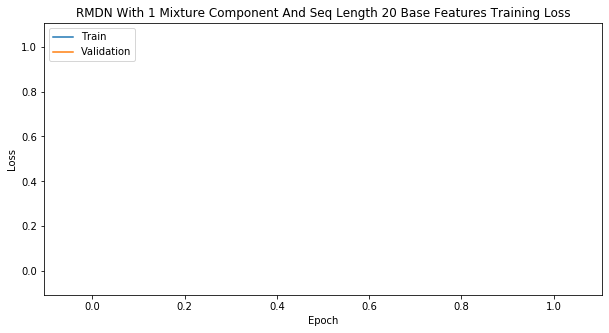

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('RMDN With {} Mixture Component And Seq Length {} Base Features Training Loss'.format(N_MIXES, SEQ_LENGTH))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Make binary class and probabilistic predictions

In [9]:
# Define helper functions

# calculate cdf of mixture
def calculate_mixture_cdf(mus, sigmas, weights, x=0):
    mixture_cdf = 0.0
    for component_num, weight in enumerate(weights):
        #print('Mu =  ', mus[component_num])
        #print('Sigma = ', sigmas[component_num])
        #print('Weight = ', weight)
        component_dist = norm(loc=mus[component_num], scale=sigmas[component_num])
        component_cdf = component_dist.cdf(x)
        #print('Component CDF = ', component_cdf)
        mixture_cdf += (component_cdf * weight)
        
    return mixture_cdf

# calculate win prob as 1 - cdf
def calculate_home_team_win_prob(mus, sigmas, weights):
    home_team_win_prob = 1 - calculate_mixture_cdf(mus, sigmas, weights)
    return home_team_win_prob

# rmdn predict function
def rmdn_predict(rmdn_model, x_gen, num_mixes, num_output_dims):
    pred_raw_params = rmdn_model.predict_generator(x_gen)
    pred_split_params = np.apply_along_axis(mdn.split_mixture_params, 1, pred_raw_params, num_output_dims, num_mixes)
    pred_split_params[:, 2, :] = np.apply_along_axis(mdn.softmax, axis=1, arr=pred_split_params[:, 2, :])
    pred_mus = pred_split_params[:, 0, :]
    pred_sigmas = np.sqrt(pred_split_params[:, 1, :])
    pred_weights = pred_split_params[:, 2, :]
    pred_win_prob = np.zeros(pred_split_params.shape[0])
    for i in range(len(pred_win_prob)):
        pred_win_prob[i] = calculate_home_team_win_prob(pred_mus[i, :], pred_sigmas[i, :], pred_weights[i, :])
        
    return pred_win_prob

In [10]:
print(train_gen[0][1].shape)

(32,)


In [12]:
# Make probabilistic predictions
Y_train_prob_pred = rmdn_predict(model, train_gen, N_MIXES, OUTPUT_DIMS)
Y_test_internal_prob_pred = rmdn_predict(model, test_internal_gen, N_MIXES, OUTPUT_DIMS)
Y_test_external_prob_pred = rmdn_predict(model, test_external_gen, N_MIXES, OUTPUT_DIMS)

# Convert to binary predictions
Y_train_class_pred = np.where(Y_train_prob_pred <= 0.5, 0, 1)
Y_test_internal_class_pred = np.where(Y_test_internal_prob_pred <= 0.5, 0, 1)
Y_test_external_class_pred = np.where(Y_test_external_prob_pred <= 0.5, 0, 1)

# Save predictions as .csv
Y_train_pred = pd.DataFrame({'class_pred':Y_train_class_pred, 'prob_pred':Y_train_prob_pred})
Y_train_pred.to_csv('./data/base_rmdn_{}mix_seq_length_{}_train_predictions.csv'.format(N_MIXES, SEQ_LENGTH), index=False)

Y_test_internal_pred = pd.DataFrame({'class_pred':Y_test_internal_class_pred, 'prob_pred':Y_test_internal_prob_pred})
Y_test_internal_pred.to_csv('./data/base_rmdn_{}mix_seq_length_{}_test_internal_predictions.csv'.format(N_MIXES, SEQ_LENGTH), index=False)

Y_test_external_pred = pd.DataFrame({'class_pred':Y_test_external_class_pred, 'prob_pred':Y_test_external_prob_pred})
Y_test_external_pred.to_csv('./data/base_rmdn_{}mix_seq_length_{}_test_external_predictions.csv'.format(N_MIXES, SEQ_LENGTH), index=False)

# Evaluate Results

In [13]:
# Classification reports
train_classification_report = classification_report(Y_train, Y_train_class_pred, target_names=['Away Team Win', 'Home Team Win'], digits=4)
test_internal_classification_report = classification_report(Y_test_internal, Y_test_internal_class_pred, target_names=['Away Team Win', 'Home Team Win'], digits=4)
test_external_classification_report = classification_report(Y_test_external, Y_test_external_class_pred, target_names=['Away Team Win', 'Home Team Win'], digits=4)

In [14]:
print(train_classification_report)

               precision    recall  f1-score   support

Away Team Win     0.6997    0.6131    0.6536    779434
Home Team Win     0.7692    0.8304    0.7986   1209790

     accuracy                         0.7453   1989224
    macro avg     0.7344    0.7218    0.7261   1989224
 weighted avg     0.7419    0.7453    0.7418   1989224



In [15]:
print(test_internal_classification_report)

               precision    recall  f1-score   support

Away Team Win     0.7276    0.6195    0.6692     96760
Home Team Win     0.7414    0.8247    0.7808    128011

     accuracy                         0.7364    224771
    macro avg     0.7345    0.7221    0.7250    224771
 weighted avg     0.7355    0.7364    0.7328    224771



In [16]:
print(test_external_classification_report)

               precision    recall  f1-score   support

Away Team Win     0.7304    0.6318    0.6775    104262
Home Team Win     0.7267    0.8076    0.7650    126379

     accuracy                         0.7281    230641
    macro avg     0.7285    0.7197    0.7213    230641
 weighted avg     0.7284    0.7281    0.7255    230641



In [17]:
# Calculate log loss
train_log_loss = log_loss(Y_train, Y_train_prob_pred)
test_internal_log_loss = log_loss(Y_test_internal, Y_test_internal_prob_pred)
test_external_log_loss = log_loss(Y_test_external, Y_test_external_prob_pred)

In [18]:
print(train_log_loss)

0.7785138704351273


In [19]:
print(test_internal_log_loss)

0.8750798482852044


In [20]:
print(test_external_log_loss)

0.8931681944905097


In [21]:
# Calculate area under ROC curve

def plot_roc_curve(true, pred, title):
    fpr, tpr, threshold = roc_curve(true, pred)
    roc_auc = auc(fpr, tpr)
    plt.title('{} ROC Curve'.format(title))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

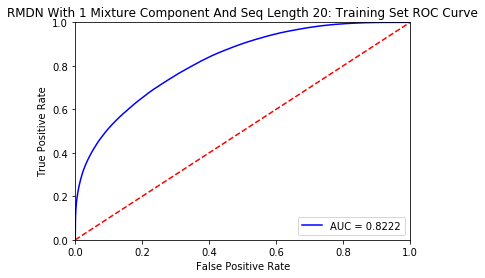

In [22]:
plot_roc_curve(Y_train, Y_train_prob_pred, 'RMDN With 1 Mixture Component And Seq Length 20: Training Set')

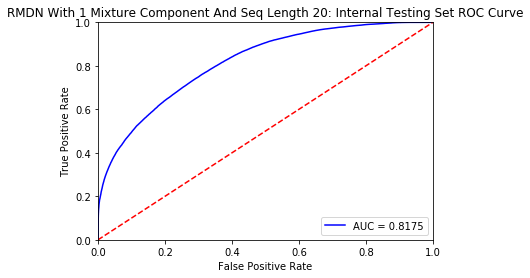

In [23]:
plot_roc_curve(Y_test_internal, Y_test_internal_prob_pred, 'RMDN With 1 Mixture Component And Seq Length 20: Internal Testing Set')

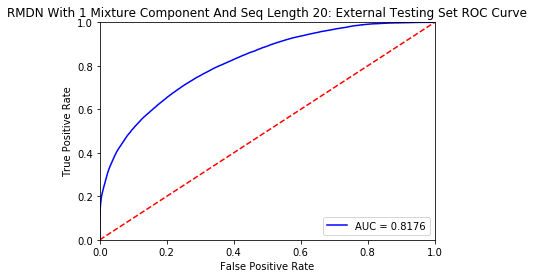

In [24]:
plot_roc_curve(Y_test_external, Y_test_external_prob_pred, 'RMDN With 1 Mixture Component And Seq Length 20: External Testing Set')